Clustering can be explained as organizing data into groups where members of a group are similar in some way. K-Means clustering is an unsupervised learning algorithm that looks for patterns in data based on similarities.

In expalining K Means Clustering, I will use the tutorial given by Microsoft in the url below. Microsoft did a bad job in explaining this tutorial properly. I will try to break the whole thing down step by step and arrive at the same conclusion as Microsoft.

https://docs.microsoft.com/en-us/sql/machine-learning/tutorials/python-clustering-model?view=sql-server-ver15

In this tutorial, we will use K Means Clustering to prepare for clustering customers, by separating customers along the following dimensions:

**orderRatio** = return order ratio (total number of orders partially or fully returned versus the total number of orders).

**itemsRatio** = return item ratio (total number of items returned versus the number of items purchased).

**monetaryRatio** = return amount ratio (total monetary amount of items returned versus the amount purchased).

**frequency** = return frequency

In [5]:
# Load packages.
import pyodbc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.spatial import distance as sci_distance
from sklearn import cluster as sk_cluster
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

# STEP 1: get your data from SQL Server and assign it to a pandas variable
conn_str = pyodbc.connect('Driver={SQL Server};' 'Server=LAPTOP-CHKIB79A;''Database=tpcxbb_1gb;''Trusted_Connection=yes;')
query_str = "SELECT ss_customer_sk AS customer,\
ROUND(COALESCE(returns_count / NULLIF(1.0*orders_count, 0), 0), 7) AS orderRatio, \
ROUND(COALESCE(returns_items / NULLIF(1.0*orders_items, 0), 0), 7) AS itemsRatio, \
ROUND(COALESCE(returns_money / NULLIF(1.0*orders_money, 0), 0), 7) AS monetaryRatio, \
COALESCE(returns_count, 0) AS frequency \
FROM \
( \
  SELECT \
    ss_customer_sk, \
    COUNT(distinct(ss_ticket_number)) AS orders_count, \
    COUNT(ss_item_sk) AS orders_items, \
    SUM( ss_net_paid ) AS orders_money \
  FROM store_sales s \
  GROUP BY ss_customer_sk \
) orders \
LEFT OUTER JOIN \
( \
  SELECT \
    sr_customer_sk, \
    count(distinct(sr_ticket_number)) as returns_count, \
    COUNT(sr_item_sk) as returns_items, \
    SUM( sr_return_amt ) AS returns_money \
FROM store_returns \
GROUP BY sr_customer_sk ) returned ON orders.ss_customer_sk=returned.sr_customer_sk"


In [6]:
df = pd.read_sql(sql=query_str, con=conn_str)
df.head()

,customer,orderRatio,itemsRatio,monetaryRatio,frequency
0,29727,0.000000,0.000000,0.000000,0
1,97643,0.068182,0.078176,0.037034,3
2,57247,0.000000,0.000000,0.000000,0
3,32549,0.086957,0.068657,0.031281,4
4,2040,0.000000,0.000000,0.000000,0


In [7]:
df1 = df.drop('customer',axis = 'columns')
df1.head()

,orderRatio,itemsRatio,monetaryRatio,frequency
0,0.000000,0.000000,0.000000,0
1,0.068182,0.078176,0.037034,3
2,0.000000,0.000000,0.000000,0
3,0.086957,0.068657,0.031281,4
4,0.000000,0.000000,0.000000,0


In [8]:
sse = []
k_rng = range(1,20)
for k in k_rng:
    km = KMeans(n_clusters=k)
    km.fit(df1)
    sse.append(km.inertia_)

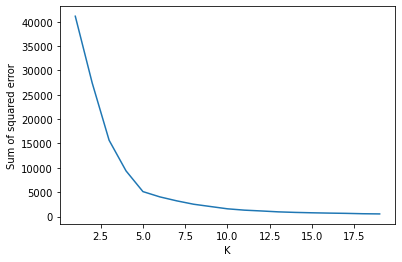

In [9]:
plt.xlabel('K')
plt.ylabel('Sum of squared error')
plt.plot(k_rng,sse)

In [10]:
# my k = 4

km = KMeans(n_clusters=4)
#y_predicted = km.fit_predict(df[['Age','Income($)']])
km = km.fit(df1)
km

KMeans(n_clusters=4)

In [11]:
# predict number of clusters
y_predicted = km.predict(df1)
y_predicted

array([0, 2, 0, ..., 0, 3, 0])

In [12]:
# assign prediction to a new column namely cluster
df['Cluster'] = y_predicted
df

,customer,orderRatio,itemsRatio,monetaryRatio,frequency,Cluster
0,29727,0.000000,0.000000,0.000000,0,0
1,97643,0.068182,0.078176,0.037034,3,2
2,57247,0.000000,0.000000,0.000000,0,0
3,32549,0.086957,0.068657,0.031281,4,2
4,2040,0.000000,0.000000,0.000000,0,0
...,...,...,...,...,...,...
37331,8134,0.000000,0.000000,0.000000,0,0
37332,41772,0.000000,0.000000,0.000000,0,0
37333,52453,0.000000,0.000000,0.000000,0,0
37334,40406,1.000000,1.000000,0.270012,1,3


In [15]:
# let's group the cluster
#print(customer_data.groupby(['cluster']).mean())
df1group = df.groupby(['Cluster']).mean()
df1group

#dfgroup = dfgroup.groupby('Cluster').agg({'customer': 'count'})

,customer,orderRatio,itemsRatio,monetaryRatio,frequency
Cluster,,,,,
0,50854.809882,0.000000,0.000000,0.000000,0.000000
1,57044.000000,1.000000,2.000000,108.719154,1.000000
2,48516.023845,0.136277,0.078346,0.044497,4.271237
3,51332.535779,0.721604,0.453365,0.307721,1.097815


### From the above, we can initially conclude that customers in cluster 0 can be targeted for marketing since they dont return goods bought. We might also decide to have limited marketing for cluster 1 since the frequency of goods return is 1. But is this assumption right? To know the answer, we need to know the number of customers in each cluster.

In [20]:
# let's find the number of customers in each cluster
customercount = df.groupby('Cluster').agg({'customer': 'count'})
customercount

,customer
Cluster,
0,31675
1,1
2,671
3,4989


### Now, we can easily conclude that it makes perfect sense to target customers in cluster 0 and ignore customers in cluster 1 because there is just one customer. In fact, we can just ignore all other clusters for marketing except cluster 0